In [1]:
cd ..

/home/mehdi2277/Documents/HarveyMuddWork/Neural_Nets_Research/neural_nets_research


In [2]:
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import datetime

from neural_nets_library import training
from tree_to_sequence.tree_encoder import TreeEncoder
from tree_to_sequence.tree_encoder_batch import TreeEncoderBatch
from tree_to_sequence.tree_decoder_batch import TreeDecoderBatch
from tree_to_sequence.program_datasets import *
from tree_to_sequence.tree_to_tree_attention_batch import TreeToTreeAttentionBatch
from functools import partial

In [3]:
num_vars = 10
num_ints = 11
one_hot = False
binarize_input = True
binarize_output = True
eos_token = True
long_base_case = True
input_as_seq = False
output_as_seq = False
num_layers = 1

In [4]:
# for_lambda_dset = ForLambdaDataset("ANC/AdditionalForDatasets/ForWithLevels/Easy-arbitraryForList.json", binarize_input=binarize_input, 
#                                    binarize_output=binarize_output, eos_token=eos_token, one_hot=one_hot, 
#                                    long_base_case=long_base_case, input_as_seq=input_as_seq,
#                                    output_as_seq=output_as_seq, num_samples=None, sort_by_length=True)
for_lambda_dset = ForLambdaDatasetLengthBatched("ANC/AdditionalForDatasets/ForWithLevels/Easy-arbitraryForList.json", 97,
                                   binarize_input=binarize_input, binarize_output=binarize_output, 
                                   eos_token=eos_token, one_hot=one_hot, 
                                   long_base_case=long_base_case, input_as_seq=input_as_seq,
                                   output_as_seq=output_as_seq, num_samples=10000)




max_size = max([item[1].size() for batch in for_lambda_dset for item in batch])

Num batches 104
total length is 10000
batch size is 97
shortest 11
longest 97
shortest 11


In [5]:
# _ = [print(x[0].size()) for x in for_lambda_dset]

# def add_index(root, index=0):
#     root.index = index
#     for child in children:
#         index = 

# for_lambda_dset_new = []
# for input_tree, target_tree in for_lambda_dset:
#     input_tree.index = 


In [6]:
def reset_all_parameters_uniform(model, stdev):
    for param in model.parameters():
        nn.init.uniform_(param, -stdev, stdev)

In [7]:
embedding_size = 4#100 #... 256 is from the paper, but 100 is WAY faster
hidden_size = 3#256
alignment_size = 50
align_type = 1
encoder_input_size = num_vars + num_ints + len(for_ops)
encoder = TreeEncoder(encoder_input_size, hidden_size, num_layers, [1, 2, 3, 4, 5], attention=True, one_hot=one_hot, binary_tree_lstm_cell=True, annotation_method=None, randomize_hiddens=False)
# encoder = TreeEncoderBatch(embedding_size, hidden_size)
nclass = num_vars + num_ints + len(lambda_ops)
plot_every = 100
max_num_children = 2 if binarize_output else 4

decoder = TreeDecoderBatch(embedding_size, hidden_size, max_num_children, nclass=nclass)
program_model = TreeToTreeAttentionBatch(encoder, decoder, hidden_size, embedding_size, nclass=nclass, max_size=max_size,
                                    alignment_size=alignment_size, align_type=align_type)
    
reset_all_parameters_uniform(program_model, 0.1)
encoder.initialize_forget_bias(3)
decoder.initialize_forget_bias(3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [8]:
# program_model = program_model.cuda()

In [9]:
optimizer = optim.Adam(program_model.parameters(), lr=0.005)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=500, factor=0.8)

In [10]:
# Counts the number of matches between the prediction and target.
def count_matches(prediction, target):
    matches = 0
    if int(prediction.value) == int(target.value):
        matches += 1
    for i in range(min(len(target.children), len(prediction.children))):
        matches += count_matches(prediction.children[i], target.children[i])
    return matches

# Program accuracy (1 if completely correct, 0 otherwise)
def program_accuracy(prediction, target):
    if prediction.size() == count_matches(prediction, target) and \
       prediction.size() == target.size():
        return 1
    else:
        return 0

# Calculate validation accuracy (this could either be program or token accuracy)
def validation_criterion(prediction, target):
    return program_accuracy(prediction, target)

In [11]:
program_model.update_max_size(max_size)

In [12]:
start = datetime.datetime.now()
with torch.cuda.device(1):
    best_model, train_plot_losses, validation_plot_losses = training.yet_another_train_func(program_model, for_lambda_dset, 
                                 optimizer, lr_scheduler=None, num_epochs=5, plot_every=1,
                                 batch_size=90, print_every=20, validation_criterion=None,
                                 use_cuda=True)
end = datetime.datetime.now()
print("TIME", end - start)

Epoch 0/4
----------
Epoch Number: 0, Batch Number: 20, Training Loss: 61.7319
Time so far is 0m 13s
Epoch Number: 0, Batch Number: 40, Training Loss: 51.2736
Time so far is 0m 24s
Epoch Number: 0, Batch Number: 60, Training Loss: 44.3589
Time so far is 0m 36s
Epoch Number: 0, Batch Number: 80, Training Loss: 39.4713
Time so far is 0m 48s
Epoch Number: 0, Batch Number: 100, Training Loss: 34.2055
Time so far is 0m 60s
just finished epoch 0
Epoch 1/4
----------
Epoch Number: 1, Batch Number: 16, Training Loss: 35.9689
Time so far is 1m 13s
Epoch Number: 1, Batch Number: 36, Training Loss: 31.2939
Time so far is 1m 24s
Epoch Number: 1, Batch Number: 56, Training Loss: 30.9448
Time so far is 1m 36s
Epoch Number: 1, Batch Number: 76, Training Loss: 33.4347
Time so far is 1m 48s
Epoch Number: 1, Batch Number: 96, Training Loss: 31.9416
Time so far is 2m 0s
just finished epoch 1
Epoch 2/4
----------
Epoch Number: 2, Batch Number: 12, Training Loss: 33.7940
Time so far is 2m 13s
Epoch Number:

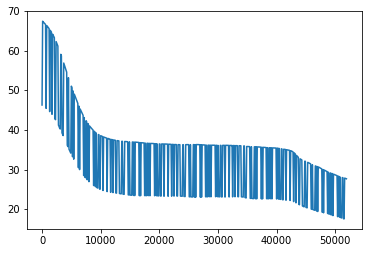

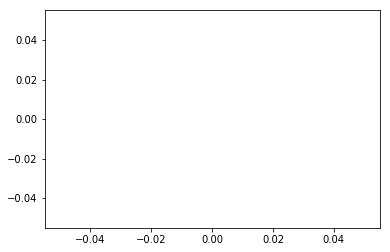

In [13]:
plt.plot([x * plot_every for x in range(len(train_plot_losses))], train_plot_losses)
plt.show()

plt.plot([x * plot_every for x in range(len(validation_plot_losses))], validation_plot_losses)
plt.show()

In [14]:
train_plot_losses_old = train_plot_losses#_old + train_plot_losses_new
validation_plot_losses_old = validation_plot_losses#_old + validation_plot_losses_new

# import csv

# torch.save(program_model, "max-big-t2t-all-vars-model")
# with open("max-big-t2t-all-vars-train.txt", "w") as output:
#     writer = csv.writer(output, lineterminator='\n')
#     for val in train_plot_losses:
#         writer.writerow([val]) 
# with open("max-big-t2t-all-vars-validation.txt", "w") as output:
#     writer = csv.writer(output, lineterminator='\n')
#     for val in validation_plot_losses:
#         writer.writerow([val]) 

In [15]:
##### n = num_ints + num_vars

# Check whether a node is syntactically valid, given its parent and index
# Then recursively do it for all the node's children
def check_valid(node, parent, child_index):
    category = parent_to_category_LAMBDA(parent, child_index, num_vars, num_ints)
    possible_outputs = category_to_child_LAMBDA(category, num_vars, num_ints)
    if not int(node.value) in possible_outputs:
        print("parent", parent, "child_index", child_index)
        print("ERROR", int(node.value), category)
        return False
    if (len(node.children) > 0):
        child1 = check_valid(node.children[0], int(node.value), 0)
        if not child1:
            return False
        child2 = check_valid(node.children[1], parent, child_index + 1)
        if not child2:
            return False
    return True

# Check all the programs in a dataset for syntactic accuracy
# (this is a debugging function used to double check the accuracy of your grammar)
def check_all():
    i = 0
    # Check grammar is right
    for prog in for_lambda_dset:
        correct = check_valid(prog[1], None, 0)
        if correct is False:
            print(i)
            pretty_print_tree(prog[1])
            return
        i += 1
        
        
        
check_all() #kangaroo

TypeError: parent_to_category_LAMBDA() takes 3 positional arguments but 4 were given

In [ ]:
import collections

import torch

class Fold(object):

    class Node(object):
        def __init__(self, op, step, index, *args):
            self.op = op
            self.step = step
            self.index = index
            self.args = args
            self.split_idx = -1
            self.batch = True

        def split(self, num):
            """Split resulting node, if function returns multiple values."""
            nodes = []
            for idx in range(num):
                nodes.append(Fold.Node(
                    self.op, self.step, self.index, *self.args))
                nodes[-1].split_idx = idx
            return tuple(nodes)

        def nobatch(self):
            self.batch = False
            return self

        def get(self, values):
            return values[self.step][self.op].get(self.index, self.split_idx)

        def __repr__(self):
            return "[%d:%d]%s" % (self.step, self.index, self.op)

    class ComputedResult(object):
        def __init__(self, batch_size, batched_result):
            self.batch_size = batch_size
            self.result = batched_result
            if isinstance(self.result, tuple):
                self.result = list(self.result)

        def try_get_batched(self, nodes):
            all_are_nodes = all(isinstance(n, Fold.Node) for n in nodes)
            num_nodes_is_equal = len(nodes) == self.batch_size
            if not all_are_nodes or not num_nodes_is_equal:
                return None

            valid_node_sequence = all(
                nodes[i].index < nodes[i + 1].index  # Indices are ordered
                and nodes[i].split_idx == nodes[i + 1].split_idx  # Same split index
                and nodes[i].step == nodes[i + 1].step  # Same step
                and nodes[i].op == nodes[i + 1].op  # Same op
                for i in range(len(nodes) - 1))
            if not valid_node_sequence:
                return None

            if nodes[0].split_idx == -1 and not isinstance(self.result, tuple):
                return self.result
            elif nodes[0].split_idx >= 0 and not isinstance(self.result[nodes[0].split_idx], tuple):
                return self.result[nodes[0].split_idx]
            else:
                # This result was already chunked.
                return None
                        res.append(
                            torch.cat([arg_item.get(values) for arg_item in arg], 0))
                else:
                    for arg_item in arg[1:]:
                        if arg_item != arg[0]:
                            raise ValueError("Can not use more then one of nobatch argument, got: %s." % str(arg_item))
                    res.append(arg[0].get(values))
            else:
                for arg_item in arg:
                    if isinstance(arg_item, Fold.Node):
                        assert arg_item.batch
                        r.append(arg_item.get(values))
                    elif isinstance(arg_item, torch.Tensor):
                        r.append(arg_item)
                res.append(torch.cat(r, 0))
        return res

    def apply(self, nn, nodes):
        """Apply current fold to given neural module."""
        self.nodes = nodes
        values = {}
        for step in sorted(self.steps.keys()):
            values[step] = {}
            for op in self.steps[step]:
                func = getattr(nn, op)
                try:
                    batched_args = self._batch_args(zip(*self.steps[step][op]), values)
                except Exception:
                    print("Error while executing node %s[%d] with args: %s" % (op, step, self.steps[step][op][0]))
                    raise
                if batched_args:
                    arg_size = batched_args[0].size()[0]
                else:
                    arg_size = 1
                res = func(*batched_args)
                values[step][op] = Fold.ComputedResult(arg_size, res)
                self.values = values
        try:
            return self._batch_args(nodes, values)
        except Exception:
            print("Retrieving %s" % nodes)
            for lst in nodes:
                if isinstance(lst[0], Fold.Node):
                    print(', '.join([str(x.get(values).size()) for x in lst]))
            raise

    def __str__(self):
        result = ''
        for step in sorted(self.steps.keys()):
            result += '%d step:\n' % step
            for op in self.steps[step]:
                first_el = ''
                for arg in self.steps[step][op][0]:
                    if first_el: first_el += ', '
                    if isinstance(arg, torch.Tensor):
                        first_el += str(arg.size())
                    else:
                        first_el += str(arg)
                result += '\t%s = %d x (%s)\n' % (op, len(self.steps[step][op]), first_el)
        return result

    def __repr__(self):
        return str(self)

                                                                                                                                           1,17          Top
